# Khai bao thư viện cân thiết

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, kpss


# Nhập dữ liệu và định dạng


In [3]:
def load_prepare_data(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        first_line = f.readline()
        
    # Kiểm tra dấu phân tách trong dòng đầu tiên
    if ';' in first_line:
        sep = ';'  # Nếu dòng đầu tiên có dấu chấm phẩy, sử dụng dấu chấm phẩy làm phân tách
    else:
        sep = ','  # Nếu không, sử dụng dấu phẩy mặc định
    
    # Đọc file CSV với sep được xác định
    df = pd.read_csv(file_path, sep=sep)

    # In danh sách các cột để kiểm tra
    print(f"Processing file: {file_path}")
    print("Columns:", df.columns.tolist())
    
    # Xử lý cột 'Price', 'Open', 'High', 'Low' nếu có dấu ngoặc kép và chuyển thành float
    for col in ['Price', 'Open', 'High', 'Low']:
        if col in df.columns:
            # Loại bỏ dấu ngoặc kép và chuyển sang kiểu float
            df[col] = df[col].replace({'"': '', ',': ''}, regex=True)
            df[col] = pd.to_numeric(df[col], errors='coerce')

    # Kiểm tra nếu có cột 'Date'
    if 'Date' in df.columns:
        try:
            # Chuyển đổi cột 'Date' về kiểu datetime và đặt làm chỉ mục
            df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y', errors='coerce').dt.date
           
        except Exception as e:
            print(f"Error converting 'Date' in {file_path}: {e}")

    # Kiểm tra nếu có các cột thời gian của crypto
    elif {'timeOpen', 'timeClose', 'timeHigh', 'timeLow'}.issubset(df.columns):
        try:
            # Chuyển đổi tất cả các cột thời gian về kiểu datetime và chỉ giữ ngày
            for time_col in ['timeOpen', 'timeClose', 'timeHigh', 'timeLow']:
                if time_col in df.columns:
                    df[time_col] = pd.to_datetime(df[time_col], errors='coerce').dt.date
            
            # Đặt 'timeClose' làm chỉ mục và bỏ các cột thời gian khác
            
            # Loại bỏ các cột thời gian không phải 'timeClose'
            time_columns_to_drop = ['timeOpen', 'timeHigh', 'timeLow']
            df.drop(columns=[col for col in time_columns_to_drop if col in df.columns], inplace=True)
            
            
        except Exception as e:
            print(f"Error converting time columns in {file_path}: {e}")
    
    else:
        print(f"No recognized date/time columns in {file_path}")
    
    return df



In [4]:
# List 11 bộ dữ liệu 

Bitcoin = load_prepare_data(r'Data\Bitcoin_5_14_2010-7_13_2010_historical_data_coinmarketcap.csv')
SP500 = load_prepare_data(r'Data\S&P 500 Historical Data.csv')
Gold = load_prepare_data(r'Data\XAU_USD Historical Data (1).csv')
Silver = load_prepare_data(r'Data\XAG_USD Historical Data.csv')
Tbond = load_prepare_data(r'Data\United States 10-Year Bond Yield Historical Data.csv')
IMUS = load_prepare_data(r'Data\Dow Jones Islamic Market US Historical Data.csv')
WTI = load_prepare_data(r'Data\WTI_USD Historical Data.csv')
Dollar = load_prepare_data(r"Data\US Dollar Index Historical Data.csv")
Franc = load_prepare_data(r'Data\CHF_USD Historical Data.csv')
Ethereum = load_prepare_data(r'Data\Ethereum_6_10_2015-8_9_2015_historical_data_coinmarketcap.csv')
Tether = load_prepare_data(r'Data\Tether USDt_2_12_2015-4_11_2015_historical_data_coinmarketcap.csv')



Processing file: Data\Bitcoin_5_14_2010-7_13_2010_historical_data_coinmarketcap.csv
Columns: ['timeOpen', 'timeClose', 'timeHigh', 'timeLow', 'name', 'open', 'high', 'low', 'close', 'volume', 'marketCap', 'timestamp']
Processing file: Data\S&P 500 Historical Data.csv
Columns: ['Date', 'Price', 'Open', 'High', 'Low', 'Vol.', 'Change %']
Processing file: Data\XAU_USD Historical Data (1).csv
Columns: ['Date', 'Price', 'Open', 'High', 'Low', 'Vol.', 'Change %']
Processing file: Data\XAG_USD Historical Data.csv
Columns: ['Date', 'Price', 'Open', 'High', 'Low', 'Vol.', 'Change %']
Processing file: Data\United States 10-Year Bond Yield Historical Data.csv
Columns: ['Date', 'Price', 'Open', 'High', 'Low', 'Change %']
Processing file: Data\Dow Jones Islamic Market US Historical Data.csv
Columns: ['Date', 'Price', 'Open', 'High', 'Low', 'Vol.', 'Change %']
Processing file: Data\WTI_USD Historical Data.csv
Columns: ['Date', 'Price', 'Open', 'High', 'Low', 'Vol.', 'Change %']
Processing file: Data

# Phân đoạn dữ liệu theo từng giai đoạn khủng hoảng

In [5]:
Bitcoin = Bitcoin.rename(columns={'timeClose': 'Date'})
Ethereum = Ethereum.rename(columns={'timeClose': 'Date'})
Tether = Tether.rename(columns={'timeClose': 'Date'})

In [6]:
Bitcoin = Bitcoin.rename(columns={'close': 'Price'})
Ethereum = Ethereum.rename(columns={'close': 'Price'})
Tether = Tether.rename(columns={'close': 'Price'})

In [7]:
# Tạo dictionary cho tất cả các tài sản
assets = {
    "SP500": SP500,
    "Gold": Gold,
    "Silver": Silver,
    "Tbond": Tbond,
    "IMUS": IMUS,
    "WTI": WTI,
    "Dollar": Dollar,
    "Franc": Franc,
    "Bitcoin": Bitcoin,
    "Ethereum": Ethereum,
    "Tether": Tether
}


In [8]:
def convert_to_datetime_index_with_copy(assets, date_column='Date', copy_column_name='Time'):
    for name, df in assets.items():
        if date_column in df.columns:
            try:
                # Chuyển đổi cột 'Date' sang kiểu datetime
                df[date_column] = pd.to_datetime(df[date_column], errors='coerce')
                
                # Loại bỏ các dòng có giá trị null trong cột 'Date' trước khi sao chép
                df.dropna(subset=[date_column], inplace=True)
                
                # Tạo một cột bản sao 'Time' từ cột 'Date'
                df[copy_column_name] = df[date_column]
                
                # Đặt cột 'Time' làm index
                df.set_index(copy_column_name, inplace=True)
                
                print(f"Đã chuyển '{date_column}' thành datetime và tạo index từ cột '{copy_column_name}' cho bộ dữ liệu {name}")
            except Exception as e:
                print(f"Lỗi khi xử lý bộ dữ liệu {name}: {e}")
        else:
            print(f"Bộ dữ liệu {name} không có cột '{date_column}'")
    return assets

# Sử dụng hàm với tập dữ liệu assets
assets = convert_to_datetime_index_with_copy(assets)

Đã chuyển 'Date' thành datetime và tạo index từ cột 'Time' cho bộ dữ liệu SP500
Đã chuyển 'Date' thành datetime và tạo index từ cột 'Time' cho bộ dữ liệu Gold
Đã chuyển 'Date' thành datetime và tạo index từ cột 'Time' cho bộ dữ liệu Silver
Đã chuyển 'Date' thành datetime và tạo index từ cột 'Time' cho bộ dữ liệu Tbond
Đã chuyển 'Date' thành datetime và tạo index từ cột 'Time' cho bộ dữ liệu IMUS
Đã chuyển 'Date' thành datetime và tạo index từ cột 'Time' cho bộ dữ liệu WTI
Đã chuyển 'Date' thành datetime và tạo index từ cột 'Time' cho bộ dữ liệu Dollar
Đã chuyển 'Date' thành datetime và tạo index từ cột 'Time' cho bộ dữ liệu Franc
Đã chuyển 'Date' thành datetime và tạo index từ cột 'Time' cho bộ dữ liệu Bitcoin
Đã chuyển 'Date' thành datetime và tạo index từ cột 'Time' cho bộ dữ liệu Ethereum
Đã chuyển 'Date' thành datetime và tạo index từ cột 'Time' cho bộ dữ liệu Tether


In [9]:
def segment_data_by_period(assets, periods, date_column='Date'):
    # Khởi tạo từ điển để lưu dữ liệu đã phân đoạn
    segmented_data = {period_name: {} for period_name in periods}

    for period_name, (start_date, end_date) in periods.items():
        # Chuyển start_date và end_date sang datetime và normalize
        start_date = pd.to_datetime(start_date).normalize()
        end_date = pd.to_datetime(end_date).normalize()

        for name, df in assets.items():
            # Chuyển cột 'Date' thành datetime và normalize nếu cần
            if date_column in df.columns:
                df[date_column] = pd.to_datetime(df[date_column]).dt.normalize()

            # Kiểm tra và in các giá trị min, max để xác nhận phạm vi thời gian
            print(f"Kiểm tra dữ liệu {name} trong giai đoạn {period_name}: {df[date_column].min()} - {df[date_column].max()}")

            if period_name == "Full sample":
                # Nếu là "Full sample", cần lấy toàn bộ dữ liệu từ `start_date` đến `end_date`
                full_date_range = pd.date_range(start=start_date, end=end_date, freq='D')
                
                # Tạo DataFrame mới với đầy đủ ngày và điền NaN cho các ngày không có dữ liệu
                df_full_sample = pd.DataFrame({date_column: full_date_range})
                if date_column in df.columns:
                    df_merged = pd.merge(df_full_sample, df, on=date_column, how='left')
                    segmented_data[period_name][name] = df_merged
                else:
                    print(f"Dữ liệu {name} không có cột {date_column}, bỏ qua.")

            else:
                # Lọc dữ liệu cho các giai đoạn khác (GFC, COVID-19)
                if df[date_column].min() <= end_date and df[date_column].max() >= start_date:
                    try:
                        # Trích xuất dữ liệu trong phạm vi
                        df_segment = df[(df[date_column] >= start_date) & (df[date_column] <= end_date)]
                        if not df_segment.empty:
                            segmented_data[period_name][name] = df_segment
                            print(f"Đã trích xuất dữ liệu cho {name} trong giai đoạn {period_name}")
                        else:
                            print(f"Tài sản {name} không có dữ liệu trong giai đoạn {period_name}")
                    except Exception as e:
                        print(f"Lỗi khi trích xuất dữ liệu cho {name} trong giai đoạn {period_name}: {e}")
                else:
                    print(f"Tài sản {name} không có dữ liệu trong giai đoạn {period_name}")

    return segmented_data


In [10]:
gfc_period = ('2008-09-12', '2008-10-10')
covid_period = ('2020-01-20', '2020-08-18')
full_sample_period = ('2002-01-02', '2020-08-18')
periods = {
    "Full sample": full_sample_period,
    "GFC": gfc_period,
    "COVID-19": covid_period
}

# Phân đoạn dữ liệu
segmented_data = segment_data_by_period(assets, periods)

Kiểm tra dữ liệu SP500 trong giai đoạn Full sample: 2002-01-02 00:00:00 - 2020-08-18 00:00:00
Kiểm tra dữ liệu Gold trong giai đoạn Full sample: 2002-01-02 00:00:00 - 2020-08-18 00:00:00
Kiểm tra dữ liệu Silver trong giai đoạn Full sample: 2002-01-02 00:00:00 - 2020-08-18 00:00:00
Kiểm tra dữ liệu Tbond trong giai đoạn Full sample: 2002-01-02 00:00:00 - 2020-08-18 00:00:00
Kiểm tra dữ liệu IMUS trong giai đoạn Full sample: 2013-05-02 00:00:00 - 2020-08-18 00:00:00
Kiểm tra dữ liệu WTI trong giai đoạn Full sample: 2002-01-02 00:00:00 - 2020-08-18 00:00:00
Kiểm tra dữ liệu Dollar trong giai đoạn Full sample: 2002-01-02 00:00:00 - 2020-08-18 00:00:00
Kiểm tra dữ liệu Franc trong giai đoạn Full sample: 2002-01-02 00:00:00 - 2020-08-18 00:00:00
Kiểm tra dữ liệu Bitcoin trong giai đoạn Full sample: 2010-07-19 00:00:00 - 2020-08-18 00:00:00
Kiểm tra dữ liệu Ethereum trong giai đoạn Full sample: 2015-08-08 00:00:00 - 2020-08-18 00:00:00
Kiểm tra dữ liệu Tether trong giai đoạn Full sample: 2015

In [11]:
def check_segmented_data(segmented_data, periods, date_column='Date'):
    # Duyệt qua từng giai đoạn và tài sản đã phân đoạn
    for period_name, assets_in_period in segmented_data.items():
        print(f"Giai đoạn: {period_name}")
        start_date, end_date = periods[period_name]  # Lấy mốc thời gian của từng giai đoạn
        start_date = pd.to_datetime(start_date).normalize()
        end_date = pd.to_datetime(end_date).normalize()

        for asset_name, df in assets_in_period.items():
            if not df.empty:  # Kiểm tra nếu DataFrame không rỗng
                print(f"  Tài sản: {asset_name}")
                
                # Kiểm tra nếu cột 'Date' tồn tại
                if date_column in df.columns:
                    # Chuyển cột 'Date' thành datetime và chuẩn hóa
                    df[date_column] = pd.to_datetime(df[date_column]).dt.normalize()
                    
                    # Lấy ngày bắt đầu và kết thúc từ cột 'Date'
                    min_date = df[date_column].min()
                    max_date = df[date_column].max()
                    
                    print(f"    Bắt đầu: {min_date}, Kết thúc: {max_date}")
                    
                    # Kiểm tra xem dữ liệu có nằm trong phạm vi giai đoạn không
                    if min_date >= start_date and max_date <= end_date:
                        print(f"    Dữ liệu hợp lệ trong phạm vi {start_date} đến {end_date}")
                    else:
                        print(f"    Lỗi: Dữ liệu không nằm trong phạm vi {start_date} đến {end_date}")
                else:
                    print(f"    Lỗi: Tài sản {asset_name} không có cột '{date_column}'")
            else:
                print(f"  Tài sản: {asset_name} - Không có dữ liệu trong giai đoạn này")
        print("-" * 40)


In [12]:
# Kiểm tra dữ liệu đã phân đoạn
check_segmented_data(segmented_data, periods)

Giai đoạn: Full sample
  Tài sản: SP500
    Bắt đầu: 2002-01-02 00:00:00, Kết thúc: 2020-08-18 00:00:00
    Dữ liệu hợp lệ trong phạm vi 2002-01-02 00:00:00 đến 2020-08-18 00:00:00
  Tài sản: Gold
    Bắt đầu: 2002-01-02 00:00:00, Kết thúc: 2020-08-18 00:00:00
    Dữ liệu hợp lệ trong phạm vi 2002-01-02 00:00:00 đến 2020-08-18 00:00:00
  Tài sản: Silver
    Bắt đầu: 2002-01-02 00:00:00, Kết thúc: 2020-08-18 00:00:00
    Dữ liệu hợp lệ trong phạm vi 2002-01-02 00:00:00 đến 2020-08-18 00:00:00
  Tài sản: Tbond
    Bắt đầu: 2002-01-02 00:00:00, Kết thúc: 2020-08-18 00:00:00
    Dữ liệu hợp lệ trong phạm vi 2002-01-02 00:00:00 đến 2020-08-18 00:00:00
  Tài sản: IMUS
    Bắt đầu: 2002-01-02 00:00:00, Kết thúc: 2020-08-18 00:00:00
    Dữ liệu hợp lệ trong phạm vi 2002-01-02 00:00:00 đến 2020-08-18 00:00:00
  Tài sản: WTI
    Bắt đầu: 2002-01-02 00:00:00, Kết thúc: 2020-08-18 00:00:00
    Dữ liệu hợp lệ trong phạm vi 2002-01-02 00:00:00 đến 2020-08-18 00:00:00
  Tài sản: Dollar
    Bắt đầu: 2

C:\Users\Legion\AppData\Local\Temp\ipykernel_11088\2785679387.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[date_column] = pd.to_datetime(df[date_column]).dt.normalize()
C:\Users\Legion\AppData\Local\Temp\ipykernel_11088\2785679387.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[date_column] = pd.to_datetime(df[date_column]).dt.normalize()
C:\Users\Legion\AppData\Local\Temp\ipykernel_11088\2785679387.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

In [13]:
segmented_data

{'Full sample': {'SP500':            Date   Price    Open    High     Low  Vol. Change %
  0    2002-01-02  1154.7  1149.0  1154.7  1136.2   NaN    0.57%
  1    2002-01-03  1165.3  1155.5  1165.3  1154.0   NaN    0.92%
  2    2002-01-04  1172.5  1171.1  1176.5  1163.4   NaN    0.62%
  3    2002-01-05     NaN     NaN     NaN     NaN   NaN      NaN
  4    2002-01-06     NaN     NaN     NaN     NaN   NaN      NaN
  ...         ...     ...     ...     ...     ...   ...      ...
  6799 2020-08-14  3372.8  3368.7  3378.5  3361.6   NaN   -0.02%
  6800 2020-08-15     NaN     NaN     NaN     NaN   NaN      NaN
  6801 2020-08-16     NaN     NaN     NaN     NaN   NaN      NaN
  6802 2020-08-17  3382.0  3380.9  3387.6  3379.2   NaN    0.27%
  6803 2020-08-18  3389.8  3387.0  3395.1  3370.2   NaN    0.23%
  
  [6804 rows x 7 columns],
  'Gold':            Date    Price     Open     High      Low  Vol. Change %
  0    2002-01-02   278.85   278.85   278.85   278.85   NaN   -0.04%
  1    2002-01-03   

In [14]:
def sort_data_by_date(segmented_data, date_column='Date'):

    sorted_data = {period: {} for period in segmented_data}

    for period, assets in segmented_data.items():
        for asset_name, df in assets.items():
            if date_column in df.columns:
                try:
                    # Sắp xếp dữ liệu theo cột ngày tháng
                    df_sorted = df.sort_values(by=date_column).reset_index(drop=True)
                    sorted_data[period][asset_name] = df_sorted
                    print(f"Sắp xếp dữ liệu cho {asset_name} trong giai đoạn {period} thành công.")
                except Exception as e:
                    print(f"Lỗi khi sắp xếp dữ liệu cho {asset_name} trong giai đoạn {period}: {e}")
            else:
                print(f"Tài sản {asset_name} không có cột {date_column}. Bỏ qua.")
    
    return sorted_data


In [15]:
segmented_data= sort_data_by_date(segmented_data)

Sắp xếp dữ liệu cho SP500 trong giai đoạn Full sample thành công.
Sắp xếp dữ liệu cho Gold trong giai đoạn Full sample thành công.
Sắp xếp dữ liệu cho Silver trong giai đoạn Full sample thành công.
Sắp xếp dữ liệu cho Tbond trong giai đoạn Full sample thành công.
Sắp xếp dữ liệu cho IMUS trong giai đoạn Full sample thành công.
Sắp xếp dữ liệu cho WTI trong giai đoạn Full sample thành công.
Sắp xếp dữ liệu cho Dollar trong giai đoạn Full sample thành công.
Sắp xếp dữ liệu cho Franc trong giai đoạn Full sample thành công.
Sắp xếp dữ liệu cho Bitcoin trong giai đoạn Full sample thành công.
Sắp xếp dữ liệu cho Ethereum trong giai đoạn Full sample thành công.
Sắp xếp dữ liệu cho Tether trong giai đoạn Full sample thành công.
Sắp xếp dữ liệu cho SP500 trong giai đoạn GFC thành công.
Sắp xếp dữ liệu cho Gold trong giai đoạn GFC thành công.
Sắp xếp dữ liệu cho Silver trong giai đoạn GFC thành công.
Sắp xếp dữ liệu cho Tbond trong giai đoạn GFC thành công.
Sắp xếp dữ liệu cho WTI trong giai đoạ

#  Tính lợi nhuận hàng ngày cho từng giai đoạn 

In [16]:

def handle_missing_values(df, price_column='Price'):
    """
    Xử lý missing values cho cột 'Price'.
    - Điền giá trị bị thiếu dưới 3 ngày bằng nội suy.
    - Giữ nguyên NaN nếu thiếu từ 3 ngày trở lên.
    """
    # Kiểm tra nếu cột 'Price' có trong DataFrame
    if price_column in df.columns:
        # Đầu tiên, xác định các khoảng thời gian liên tiếp bị thiếu
        df['Missing'] = df[price_column].isna()
        df['Missing_Group'] = (df['Missing'] != df['Missing'].shift()).cumsum()
        
        # Đếm số lượng ngày liên tiếp bị thiếu
        missing_counts = df.groupby('Missing_Group')['Missing'].transform('sum')
        
        # Sử dụng nội suy cho các khoảng thời gian bị thiếu dưới 3 ngày
        df.loc[(df['Missing']) & (missing_counts < 3), price_column] = df[price_column].interpolate(method='linear')
        
        # Xóa các cột tạm thời
        df.drop(['Missing', 'Missing_Group'], axis=1, inplace=True)
    
    return df

In [17]:


def log_returns(segmented_data, price_column='Price'):
    """
    Tính toán log return sau khi xử lý missing values cho từng giai đoạn và từng tài sản.
    """
    # Tạo dictionary để lưu trữ log returns cho từng giai đoạn
    log_returns_data = {period: {} for period in segmented_data}

    # Duyệt qua từng giai đoạn và từng tài sản
    for period, assets in segmented_data.items():
        for asset_name, df in assets.items():
            if price_column in df.columns:
                try:
                    # Xử lý missing values cho cột 'Price'
                    df = handle_missing_values(df, price_column)
                    
                    # Tính log return
                    df['Log Return'] = np.log(df[price_column] / df[price_column].shift(1))
                    
                    # Lưu DataFrame đã tính log return vào dictionary
                    log_returns_data[period][asset_name] = df
                    print(f"Tính Log Return cho {asset_name} trong giai đoạn {period} thành công.")
                except Exception as e:
                    print(f"Lỗi khi tính toán Log Return cho {asset_name} trong giai đoạn {period}: {e}")
            else:
                print(f"Tài sản {asset_name} không có cột {price_column}. Bỏ qua.")

    return log_returns_data

In [18]:

log_returns_data = log_returns(segmented_data)

# Kiểm tra kết quả
for period, assets in log_returns_data.items():
    for asset, df in assets.items():
        print(f"{asset} - {period}:")
        print(df[['Date', 'Price', 'Log Return']].head())

Tính Log Return cho SP500 trong giai đoạn Full sample thành công.
Tính Log Return cho Gold trong giai đoạn Full sample thành công.
Tính Log Return cho Silver trong giai đoạn Full sample thành công.
Tính Log Return cho Tbond trong giai đoạn Full sample thành công.
Tính Log Return cho IMUS trong giai đoạn Full sample thành công.
Tính Log Return cho WTI trong giai đoạn Full sample thành công.
Tính Log Return cho Dollar trong giai đoạn Full sample thành công.
Tính Log Return cho Franc trong giai đoạn Full sample thành công.
Tính Log Return cho Bitcoin trong giai đoạn Full sample thành công.
Tính Log Return cho Ethereum trong giai đoạn Full sample thành công.
Tính Log Return cho Tether trong giai đoạn Full sample thành công.
Tính Log Return cho SP500 trong giai đoạn GFC thành công.
Tính Log Return cho Gold trong giai đoạn GFC thành công.
Tính Log Return cho Silver trong giai đoạn GFC thành công.
Tính Log Return cho Tbond trong giai đoạn GFC thành công.
Tính Log Return cho WTI trong giai đoạ

In [19]:
log_returns_data['COVID-19']['Bitcoin']

,Date,name,open,high,low,Price,volume,marketCap,timestamp,Log Return
0,2020-01-20,2781,8704.631814,8745.590797,8560.474043,8657.642939,2.642238e+10,1.573276e+11,2020-01-20T23:59:59.999Z,NaN
1,2020-01-21,2781,8658.991183,8755.706296,8544.520453,8745.894788,2.409742e+10,1.589480e+11,2020-01-21T23:59:59.999Z,0.010142
2,2020-01-22,2781,8744.210751,8792.993871,8636.747435,8680.876042,2.260020e+10,1.577833e+11,2020-01-22T23:59:59.999Z,-0.007462
3,2020-01-23,2781,8680.650560,8687.747088,8333.637874,8406.516068,2.577068e+10,1.528133e+11,2020-01-23T23:59:59.999Z,-0.032115
4,2020-01-24,2781,8405.567733,8514.667035,8266.840578,8445.434282,2.439791e+10,1.535368e+11,2020-01-24T23:59:59.999Z,0.004619
...,...,...,...,...,...,...,...,...,...,...
207,2020-08-14,2781,11772.659386,12150.993668,11685.455481,11768.870619,2.423796e+10,2.172651e+11,2020-08-14T23:59:59.999Z,-0.001296
208,2020-08-15,2781,11768.697144,11963.203065,11768.697144,11865.698570,2.335492e+10,2.190644e+11,2020-08-15T23:59:59.999Z,0.008194
209,2020-08-16,2781,11866.685580,11934.900915,11737.188599,11892.804063,2.058338e+10,2.195761e+11,2020-08-16T23:59:59.999Z,0.002282
210,2020-08-17,2781,11895.657774,12359.057022,11806.695882,12254.401908,2.822769e+10,2.262617e+11,2020-08-17T23:59:59.999Z,0.029952


#  Descriptive statistics

In [20]:
from scipy.stats import skew, kurtosis, jarque_bera

In [21]:


def generate_summary_table(log_returns_data, periods):
    data_list = []

    for period, data_dict in log_returns_data.items():
        for asset, df in data_dict.items():
            # Tính các thống kê cho từng tài sản và từng giai đoạn
            mean = df['Log Return'].mean()
            std_dev = df['Log Return'].std()
            sharpe_ratio = mean / std_dev if std_dev != 0 else 0
            skewness = df['Log Return'].skew()
            kurtosis = df['Log Return'].kurtosis()
            jb_stat, jb_p_value = jarque_bera(df['Log Return'])

            # Lưu kết quả vào list
            data_list.append({
                'Variable': asset,
                'Period': period,
                'Mean': mean,
                'Std. Dev.': std_dev,
                'Sharpe Ratio': sharpe_ratio,
                'Skewness': skewness,
                'Kurtosis': kurtosis,
                'Jarque-Bera': jb_stat
            })

    return pd.DataFrame(data_list)

# Tạo DataFrame từ hàm generate_summary_table
summary_df = generate_summary_table(log_returns_data, periods)

# Kiểm tra lại nội dung của summary_df
print(summary_df.columns)
print(summary_df.head())


Index(['Variable', 'Period', 'Mean', 'Std. Dev.', 'Sharpe Ratio', 'Skewness',
       'Kurtosis', 'Jarque-Bera'],
      dtype='object')
  Variable       Period      Mean  Std. Dev.  Sharpe Ratio  Skewness  \
0    SP500  Full sample  0.000177   0.009640      0.018371 -0.230162   
1     Gold  Full sample  0.000283   0.008629      0.032825 -0.207355   
2   Silver  Full sample  0.000261   0.015221      0.017138 -1.302112   
3    Tbond  Full sample -0.000346   0.019910     -0.017354  1.005520   
4     IMUS  Full sample  0.000343   0.008450      0.040615 -0.152356   

    Kurtosis  Jarque-Bera  
0  14.911229          NaN  
1   9.902499          NaN  
2  15.583347          NaN  
3  48.639075          NaN  
4  22.693483          NaN  


In [22]:
summary_df

,Variable,Period,Mean,Std. Dev.,Sharpe Ratio,Skewness,Kurtosis,Jarque-Bera
0,SP500,Full sample,0.000177,0.009640,0.018371,-0.230162,14.911229,NaN
1,Gold,Full sample,0.000283,0.008629,0.032825,-0.207355,9.902499,NaN
2,Silver,Full sample,0.000261,0.015221,0.017138,-1.302112,15.583347,NaN
3,Tbond,Full sample,-0.000346,0.019910,-0.017354,1.005520,48.639075,NaN
4,IMUS,Full sample,0.000343,0.008450,0.040615,-0.152356,22.693483,NaN
5,WTI,Full sample,0.000020,0.020350,0.000978,-2.119948,44.699224,NaN
6,Dollar,Full sample,-0.000031,0.003905,-0.007886,0.038305,4.386672,NaN
7,Franc,Full sample,0.000088,0.005477,0.016056,3.963822,155.212311,NaN
8,Bitcoin,Full sample,0.003256,0.054348,0.059917,-1.080287,19.715836,NaN
9,Ethereum,Full sample,0.003447,0.062766,0.054919,0.087398,8.123639,NaN


In [23]:
segmented_data["GFC"]["Franc"]

,Date,Price,Open,High,Low,Vol.,Change %,Log Return
0,2008-09-12,0.8845,0.8795,0.8857,0.8770,NaN,0.51%,NaN
1,2008-09-15,0.8972,0.8936,0.9045,0.8864,NaN,1.44%,0.014256
2,2008-09-16,0.8911,0.8976,0.9053,0.8891,NaN,-0.68%,-0.006822
3,2008-09-17,0.9057,0.8908,0.9099,0.8889,NaN,1.64%,0.016251
4,2008-09-18,0.9031,0.9051,0.9176,0.9000,NaN,-0.29%,-0.002875
5,2008-09-19,0.9048,0.9029,0.9085,0.8863,NaN,0.19%,0.001881
6,2008-09-22,0.9304,0.9056,0.9351,0.9045,NaN,2.83%,0.027901
7,2008-09-23,0.9201,0.9314,0.9324,0.9181,NaN,-1.11%,-0.011132
8,2008-09-24,0.9159,0.9192,0.9258,0.9155,NaN,-0.46%,-0.004575
9,2008-09-25,0.9181,0.9157,0.9258,0.9137,NaN,0.24%,0.002399


In [24]:
segmented_data["COVID-19"]["Bitcoin"]

,Date,name,open,high,low,Price,volume,marketCap,timestamp,Log Return
0,2020-01-20,2781,8704.631814,8745.590797,8560.474043,8657.642939,2.642238e+10,1.573276e+11,2020-01-20T23:59:59.999Z,NaN
1,2020-01-21,2781,8658.991183,8755.706296,8544.520453,8745.894788,2.409742e+10,1.589480e+11,2020-01-21T23:59:59.999Z,0.010142
2,2020-01-22,2781,8744.210751,8792.993871,8636.747435,8680.876042,2.260020e+10,1.577833e+11,2020-01-22T23:59:59.999Z,-0.007462
3,2020-01-23,2781,8680.650560,8687.747088,8333.637874,8406.516068,2.577068e+10,1.528133e+11,2020-01-23T23:59:59.999Z,-0.032115
4,2020-01-24,2781,8405.567733,8514.667035,8266.840578,8445.434282,2.439791e+10,1.535368e+11,2020-01-24T23:59:59.999Z,0.004619
...,...,...,...,...,...,...,...,...,...,...
207,2020-08-14,2781,11772.659386,12150.993668,11685.455481,11768.870619,2.423796e+10,2.172651e+11,2020-08-14T23:59:59.999Z,-0.001296
208,2020-08-15,2781,11768.697144,11963.203065,11768.697144,11865.698570,2.335492e+10,2.190644e+11,2020-08-15T23:59:59.999Z,0.008194
209,2020-08-16,2781,11866.685580,11934.900915,11737.188599,11892.804063,2.058338e+10,2.195761e+11,2020-08-16T23:59:59.999Z,0.002282
210,2020-08-17,2781,11895.657774,12359.057022,11806.695882,12254.401908,2.822769e+10,2.262617e+11,2020-08-17T23:59:59.999Z,0.029952


# Merge Data

In [25]:


# Rename the 'Log Return' column in SP500 data to a unique name before merging
sp500_log_return = log_returns_data['Full sample']['SP500'][['Date', 'Log Return']].rename(columns={'Log Return': 'SP500_Log_Return'})

# Merge with the Bitcoin data (or any other asset) based on 'Date'
merged_data_bitcoin = log_returns_data['Full sample']['Bitcoin'].merge(sp500_log_return, on='Date', how='left')

# Display the result
merged_data_bitcoin


,Date,name,open,high,low,Price,volume,marketCap,timestamp,Log Return,SP500_Log_Return
0,2002-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2002-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.009138
2,2002-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.006160
3,2002-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.002163
4,2002-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.002168
...,...,...,...,...,...,...,...,...,...,...,...
6799,2020-08-14,2781.0,11772.659386,12150.993668,11685.455481,11768.870619,2.423796e+10,2.172651e+11,2020-08-14T23:59:59.999Z,-0.001296,-0.000178
6800,2020-08-15,2781.0,11768.697144,11963.203065,11768.697144,11865.698570,2.335492e+10,2.190644e+11,2020-08-15T23:59:59.999Z,0.008194,0.000909
6801,2020-08-16,2781.0,11866.685580,11934.900915,11737.188599,11892.804063,2.058338e+10,2.195761e+11,2020-08-16T23:59:59.999Z,0.002282,0.000908
6802,2020-08-17,2781.0,11895.657774,12359.057022,11806.695882,12254.401908,2.822769e+10,2.262617e+11,2020-08-17T23:59:59.999Z,0.029952,0.000907


In [26]:


# Rename the 'Log Return' column in SP500 data to a unique name before merging
sp500_log_return = log_returns_data['Full sample']['SP500'][['Date', 'Log Return']].rename(columns={'Log Return': 'SP500_Log_Return'})

# Merge with the Bitcoin data (or any other asset) based on 'Date'
merged_data_dollar = log_returns_data['Full sample']['Dollar'].merge(sp500_log_return, on='Date', how='left')

# Display the result
merged_data_dollar

,Date,Price,Open,High,Low,Vol.,Change %,Log Return,SP500_Log_Return
0,2002-01-02,115.790000,116.40,116.93,115.55,NaN,-0.82%,NaN,NaN
1,2002-01-03,116.110000,115.88,116.33,115.54,NaN,0.28%,0.002760,0.009138
2,2002-01-04,116.330000,116.07,116.53,115.97,NaN,0.19%,0.001893,0.006160
3,2002-01-05,116.330000,NaN,NaN,NaN,NaN,NaN,0.000000,-0.002163
4,2002-01-06,116.330000,NaN,NaN,NaN,NaN,NaN,0.000000,-0.002168
...,...,...,...,...,...,...,...,...,...
6799,2020-08-14,93.100000,93.22,93.41,93.01,NaN,-0.26%,-0.002467,-0.000178
6800,2020-08-15,93.016667,NaN,NaN,NaN,NaN,NaN,-0.000895,0.000909
6801,2020-08-16,92.933333,NaN,NaN,NaN,NaN,NaN,-0.000896,0.000908
6802,2020-08-17,92.850000,93.10,93.12,92.77,NaN,-0.26%,-0.000897,0.000907


In [27]:


# Rename the 'Log Return' column in SP500 data to a unique name before merging
sp500_log_return = log_returns_data['Full sample']['SP500'][['Date', 'Log Return']].rename(columns={'Log Return': 'SP500_Log_Return'})

# Merge with the Bitcoin data (or any other asset) based on 'Date'
merged_data_ether = log_returns_data['Full sample']['Ethereum'].merge(sp500_log_return, on='Date', how='left')

# Display the result
merged_data_ether

,Date,name,open,high,low,Price,volume,marketCap,timestamp,Log Return,SP500_Log_Return
0,2002-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2002-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.009138
2,2002-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.006160
3,2002-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.002163
4,2002-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.002168
...,...,...,...,...,...,...,...,...,...,...,...
6799,2020-08-14,2781.0,393.108354,396.208097,392.163415,394.366740,1.401115e+10,4.423043e+10,2020-08-14T23:59:59.999Z,0.000000,-0.000178
6800,2020-08-15,2781.0,434.054795,437.676178,430.385536,432.871369,1.554830e+10,4.856074e+10,2020-08-15T23:59:59.999Z,0.093159,0.000909
6801,2020-08-16,2781.0,433.350598,436.265829,415.086255,433.786610,1.216882e+10,4.867516e+10,2020-08-16T23:59:59.999Z,0.002112,0.000908
6802,2020-08-17,2781.0,433.973761,442.734974,422.647281,429.531252,1.322709e+10,4.820343e+10,2020-08-17T23:59:59.999Z,-0.009858,0.000907


In [28]:


# Rename the 'Log Return' column in SP500 data to a unique name before merging
sp500_log_return = log_returns_data['Full sample']['SP500'][['Date', 'Log Return']].rename(columns={'Log Return': 'SP500_Log_Return'})

# Merge with the Bitcoin data (or any other asset) based on 'Date'
merged_data_franc = log_returns_data['Full sample']['Franc'].merge(sp500_log_return, on='Date', how='left')

# Display the result
merged_data_franc

,Date,Price,Open,High,Low,Vol.,Change %,Log Return,SP500_Log_Return
0,2002-01-02,0.608200,0.6081,0.6082,0.6081,NaN,0.95%,NaN,NaN
1,2002-01-03,0.606100,0.6060,0.6061,0.6060,NaN,-0.35%,-0.003459,0.009138
2,2002-01-04,0.605400,0.6053,0.6054,0.6053,NaN,-0.12%,-0.001156,0.006160
3,2002-01-05,0.605733,NaN,NaN,NaN,NaN,NaN,0.000550,-0.002163
4,2002-01-06,0.606067,NaN,NaN,NaN,NaN,NaN,0.000550,-0.002168
...,...,...,...,...,...,...,...,...,...
6799,2020-08-14,1.100000,1.0984,1.1006,1.0960,33.74K,0.10%,0.001001,-0.000178
6800,2020-08-15,1.100933,NaN,NaN,NaN,NaN,NaN,0.000848,0.000909
6801,2020-08-16,1.101867,NaN,NaN,NaN,NaN,NaN,0.000847,0.000908
6802,2020-08-17,1.102800,1.0992,1.1049,1.0989,31.12K,0.25%,0.000847,0.000907


In [29]:


# Rename the 'Log Return' column in SP500 data to a unique name before merging
sp500_log_return = log_returns_data['Full sample']['SP500'][['Date', 'Log Return']].rename(columns={'Log Return': 'SP500_Log_Return'})

# Merge with the Bitcoin data (or any other asset) based on 'Date'
merged_data_gold = log_returns_data['Full sample']['Gold'].merge(sp500_log_return, on='Date', how='left')

# Display the result
merged_data_gold

,Date,Price,Open,High,Low,Vol.,Change %,Log Return,SP500_Log_Return
0,2002-01-02,278.850000,278.85,278.85,278.85,NaN,-0.04%,NaN,NaN
1,2002-01-03,278.450000,278.85,278.45,278.45,NaN,-0.14%,-0.001435,0.009138
2,2002-01-04,278.950000,278.55,278.95,278.95,NaN,0.18%,0.001794,0.006160
3,2002-01-05,278.883333,NaN,NaN,NaN,NaN,NaN,-0.000239,-0.002163
4,2002-01-06,278.816667,NaN,NaN,NaN,NaN,NaN,-0.000239,-0.002168
...,...,...,...,...,...,...,...,...,...
6799,2020-08-14,1944.290000,1953.98,1962.62,1932.46,NaN,-0.50%,-0.004982,-0.000178
6800,2020-08-15,1958.260000,NaN,NaN,NaN,NaN,NaN,0.007159,0.000909
6801,2020-08-16,1972.230000,NaN,NaN,NaN,NaN,NaN,0.007109,0.000908
6802,2020-08-17,1986.200000,1946.22,1990.91,1929.74,NaN,2.16%,0.007058,0.000907


In [30]:


# Rename the 'Log Return' column in SP500 data to a unique name before merging
sp500_log_return = log_returns_data['Full sample']['SP500'][['Date', 'Log Return']].rename(columns={'Log Return': 'SP500_Log_Return'})

# Merge with the Bitcoin data (or any other asset) based on 'Date'
merged_data_imus = log_returns_data['Full sample']['IMUS'].merge(sp500_log_return, on='Date', how='left')

# Display the result
merged_data_imus

,Date,Price,Open,High,Low,Vol.,Change %,Log Return,SP500_Log_Return
0,2002-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2002-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.009138
2,2002-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.006160
3,2002-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.002163
4,2002-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.002168
...,...,...,...,...,...,...,...,...,...
6799,2020-08-14,6811.750000,6821.52,6824.27,6790.12,NaN,-0.14%,-0.001433,-0.000178
6800,2020-08-15,6830.213333,NaN,NaN,NaN,NaN,NaN,0.002707,0.000909
6801,2020-08-16,6848.676667,NaN,NaN,NaN,NaN,NaN,0.002700,0.000908
6802,2020-08-17,6867.140000,6811.75,6874.37,6811.75,NaN,0.81%,0.002692,0.000907


In [31]:


# Rename the 'Log Return' column in SP500 data to a unique name before merging
sp500_log_return = log_returns_data['Full sample']['SP500'][['Date', 'Log Return']].rename(columns={'Log Return': 'SP500_Log_Return'})

# Merge with the Bitcoin data (or any other asset) based on 'Date'
merged_data_sp500 = log_returns_data['Full sample']['SP500'].merge(sp500_log_return, on='Date', how='left')

# Display the result
merged_data_sp500

,Date,Price,Open,High,Low,Vol.,Change %,Log Return,SP500_Log_Return
0,2002-01-02,1154.700000,1149.0,1154.7,1136.2,NaN,0.57%,NaN,NaN
1,2002-01-03,1165.300000,1155.5,1165.3,1154.0,NaN,0.92%,0.009138,0.009138
2,2002-01-04,1172.500000,1171.1,1176.5,1163.4,NaN,0.62%,0.006160,0.006160
3,2002-01-05,1169.966667,NaN,NaN,NaN,NaN,NaN,-0.002163,-0.002163
4,2002-01-06,1167.433333,NaN,NaN,NaN,NaN,NaN,-0.002168,-0.002168
...,...,...,...,...,...,...,...,...,...
6799,2020-08-14,3372.800000,3368.7,3378.5,3361.6,NaN,-0.02%,-0.000178,-0.000178
6800,2020-08-15,3375.866667,NaN,NaN,NaN,NaN,NaN,0.000909,0.000909
6801,2020-08-16,3378.933333,NaN,NaN,NaN,NaN,NaN,0.000908,0.000908
6802,2020-08-17,3382.000000,3380.9,3387.6,3379.2,NaN,0.27%,0.000907,0.000907


In [32]:


# Rename the 'Log Return' column in SP500 data to a unique name before merging
sp500_log_return = log_returns_data['Full sample']['SP500'][['Date', 'Log Return']].rename(columns={'Log Return': 'SP500_Log_Return'})

# Merge with the Bitcoin data (or any other asset) based on 'Date'
merged_data_silver = log_returns_data['Full sample']['Silver'].merge(sp500_log_return, on='Date', how='left')

# Display the result
merged_data_silver

,Date,Price,Open,High,Low,Vol.,Change %,Log Return,SP500_Log_Return
0,2002-01-02,4.580000,4.6000,4.5800,4.5700,NaN,-0.87%,NaN,NaN
1,2002-01-03,4.650000,4.5600,4.6500,4.6400,NaN,1.53%,0.015168,0.009138
2,2002-01-04,4.700000,4.6400,4.7000,4.6900,NaN,1.08%,0.010695,0.006160
3,2002-01-05,4.716667,NaN,NaN,NaN,NaN,NaN,0.003540,-0.002163
4,2002-01-06,4.733333,NaN,NaN,NaN,NaN,NaN,0.003527,-0.002168
...,...,...,...,...,...,...,...,...,...
6799,2020-08-14,26.410000,27.5230,27.7240,25.7483,NaN,-4.16%,-0.042441,-0.000178
6800,2020-08-15,26.740000,NaN,NaN,NaN,NaN,NaN,0.012418,0.000909
6801,2020-08-16,27.070000,NaN,NaN,NaN,NaN,NaN,0.012266,0.000908
6802,2020-08-17,27.400000,26.6418,27.5712,25.8305,NaN,3.75%,0.012117,0.000907


In [33]:


# Rename the 'Log Return' column in SP500 data to a unique name before merging
sp500_log_return = log_returns_data['Full sample']['SP500'][['Date', 'Log Return']].rename(columns={'Log Return': 'SP500_Log_Return'})

# Merge with the Bitcoin data (or any other asset) based on 'Date'
merged_data_tbond = log_returns_data['Full sample']['Tbond'].merge(sp500_log_return, on='Date', how='left')

# Display the result
merged_data_tbond

,Date,Price,Open,High,Low,Change %,Log Return,SP500_Log_Return
0,2002-01-02,5.160000,5.160,5.160,5.160,2.60%,NaN,NaN
1,2002-01-03,5.111000,5.111,5.111,5.111,-0.95%,-0.009541,0.009138
2,2002-01-04,5.125000,5.125,5.125,5.125,0.27%,0.002735,0.006160
3,2002-01-05,5.099667,NaN,NaN,NaN,NaN,-0.004955,-0.002163
4,2002-01-06,5.074333,NaN,NaN,NaN,NaN,-0.004980,-0.002168
...,...,...,...,...,...,...,...,...
6799,2020-08-14,0.709000,0.717,0.722,0.690,-1.13%,-0.011220,-0.000178
6800,2020-08-15,0.703333,NaN,NaN,NaN,NaN,-0.008025,0.000909
6801,2020-08-16,0.697667,NaN,NaN,NaN,NaN,-0.008090,0.000908
6802,2020-08-17,0.692000,0.713,0.714,0.667,-2.52%,-0.008155,0.000907


In [34]:


# Rename the 'Log Return' column in SP500 data to a unique name before merging
sp500_log_return = log_returns_data['Full sample']['SP500'][['Date', 'Log Return']].rename(columns={'Log Return': 'SP500_Log_Return'})

# Merge with the Bitcoin data (or any other asset) based on 'Date'
merged_data_tether = log_returns_data['Full sample']['Tether'].merge(sp500_log_return, on='Date', how='left')

# Display the result
merged_data_tether

,Date,name,open,high,low,Price,volume,marketCap,timestamp,Log Return,SP500_Log_Return
0,2002-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2002-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.009138
2,2002-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.006160
3,2002-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.002163
4,2002-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.002168
...,...,...,...,...,...,...,...,...,...,...,...
6799,2020-08-14,2781.0,1.021125,1.025900,0.991814,1.001024,3.841775e+10,1.000846e+10,2020-08-14T23:59:59.999Z,-0.018985,-0.000178
6800,2020-08-15,2781.0,1.001003,1.010070,0.998149,1.001032,3.868112e+10,1.000854e+10,2020-08-15T23:59:59.999Z,0.000008,0.000909
6801,2020-08-16,2781.0,1.001093,1.008545,0.997908,1.001881,3.560332e+10,1.001703e+10,2020-08-16T23:59:59.999Z,0.000847,0.000908
6802,2020-08-17,2781.0,1.001907,1.016629,0.996617,1.000111,4.304721e+10,9.999327e+09,2020-08-17T23:59:59.999Z,-0.001768,0.000907


In [35]:


# Rename the 'Log Return' column in SP500 data to a unique name before merging
sp500_log_return = log_returns_data['Full sample']['SP500'][['Date', 'Log Return']].rename(columns={'Log Return': 'SP500_Log_Return'})

# Merge with the Bitcoin data (or any other asset) based on 'Date'
merged_data_wti = log_returns_data['Full sample']['WTI'].merge(sp500_log_return, on='Date', how='left')

# Display the result
merged_data_wti

,Date,Price,Open,High,Low,Vol.,Change %,Log Return,SP500_Log_Return
0,2002-01-02,20.060000,19.91,21.06,19.73,NaN,1.11%,NaN,NaN
1,2002-01-03,20.770000,21.16,21.36,19.84,NaN,3.54%,0.034782,0.009138
2,2002-01-04,21.180000,20.64,21.93,20.63,NaN,1.97%,0.019548,0.006160
3,2002-01-05,21.246667,NaN,NaN,NaN,NaN,NaN,0.003143,-0.002163
4,2002-01-06,21.313333,NaN,NaN,NaN,NaN,NaN,0.003133,-0.002168
...,...,...,...,...,...,...,...,...,...
6799,2020-08-14,23.760000,23.73,23.78,23.45,NaN,0.04%,0.000421,-0.000178
6800,2020-08-15,23.940000,NaN,NaN,NaN,NaN,NaN,0.007547,0.000909
6801,2020-08-16,24.120000,24.05,24.17,24.00,NaN,1.52%,0.007491,0.000908
6802,2020-08-17,24.500000,24.12,24.57,23.95,NaN,1.58%,0.015632,0.000907


In [36]:
assets_to_modify = {
    "bitcoin": merged_data_bitcoin,
    "gold": merged_data_gold,
    "silver": merged_data_silver,
    "tbond": merged_data_tbond,
    "dollar": merged_data_dollar,
    "imus": merged_data_imus,
    "wti": merged_data_wti,
    "franc": merged_data_franc,
    "ether": merged_data_ether,
    "tether": merged_data_tether
}

In [37]:
merged_data_dollar

,Date,Price,Open,High,Low,Vol.,Change %,Log Return,SP500_Log_Return
0,2002-01-02,115.790000,116.40,116.93,115.55,NaN,-0.82%,NaN,NaN
1,2002-01-03,116.110000,115.88,116.33,115.54,NaN,0.28%,0.002760,0.009138
2,2002-01-04,116.330000,116.07,116.53,115.97,NaN,0.19%,0.001893,0.006160
3,2002-01-05,116.330000,NaN,NaN,NaN,NaN,NaN,0.000000,-0.002163
4,2002-01-06,116.330000,NaN,NaN,NaN,NaN,NaN,0.000000,-0.002168
...,...,...,...,...,...,...,...,...,...
6799,2020-08-14,93.100000,93.22,93.41,93.01,NaN,-0.26%,-0.002467,-0.000178
6800,2020-08-15,93.016667,NaN,NaN,NaN,NaN,NaN,-0.000895,0.000909
6801,2020-08-16,92.933333,NaN,NaN,NaN,NaN,NaN,-0.000896,0.000908
6802,2020-08-17,92.850000,93.10,93.12,92.77,NaN,-0.26%,-0.000897,0.000907


In [38]:
#  LSTM

In [40]:
import tensorflow as tf
import sklearn 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler


# Example for one asset (e.g., 'Bitcoin')
asset_df = assets_to_modify["bitcoin"].copy()

# Ensure Date is sorted
asset_df = asset_df.sort_values('Date')

# Use Log Return column and drop any NaNs
asset_df = asset_df[['Date', 'Log Return']].dropna()

# Scale the Log Return data
scaler = MinMaxScaler(feature_range=(0, 1))
asset_df['Log Return'] = scaler.fit_transform(asset_df[['Log Return']])

# Prepare training data for LSTM
sequence_length = 60  # Number of days to look back
X, y = [], []

for i in range(sequence_length, len(asset_df)):
    X.append(asset_df['Log Return'].values[i-sequence_length:i])
    y.append(asset_df['Log Return'].values[i])

X, y = np.array(X), np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))  # Reshape for LSTM [samples, time steps, features]

# LSTM Model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))  # Single output for regression

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X, y, epochs=50, batch_size=32)

# Predictions (example: forecasting the next day based on the last 60 days)
last_60_days = asset_df['Log Return'][-sequence_length:].values
last_60_days = scaler.transform(last_60_days.reshape(-1, 1))
last_60_days = np.reshape(last_60_days, (1, sequence_length, 1))

predicted_price = model.predict(last_60_days)
predicted_price = scaler.inverse_transform(predicted_price)

print("Predicted Log Return for the next day:", predicted_price[0][0])


c:\Users\Legion\Documents\PythonStatsProject\PythonStatsProject\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - loss: 0.0462
Epoch 2/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - loss: 0.0059
Epoch 3/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - loss: 0.0051
Epoch 4/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - loss: 0.0045
Epoch 5/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - loss: 0.0045
Epoch 6/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - loss: 0.0049
Epoch 7/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - loss: 0.0039
Epoch 8/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - loss: 0.0043
Epoch 9/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 0.0045
Epoch 10/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 0.0042
Epoch 11/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 0.0039
Epoch 12/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 0.0040
Epoch 13/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 0.0042
Epoch 14/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.0040
Epoch 15/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 4

c:\Users\Legion\Documents\PythonStatsProject\PythonStatsProject\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted Log Return for the next day: 0.037671622


# predict 3 months a head for various assets using LSTM

In [41]:


# Define a function to prepare data, train the model, and predict for multiple assets
def train_lstm_and_predict(assets_data, sequence_length=60, predict_days=90):
    predictions = {}

    for asset_name, df in assets_data.items():
        # Ensure Date is sorted
        df = df.sort_values('Date')

        # Use Log Return column, drop NaNs, and add Price if not present
        df = df[['Date', 'Log Return', 'Price']].dropna()

        # Scale the Log Return data
        scaler = MinMaxScaler(feature_range=(0, 1))
        df['Log Return'] = scaler.fit_transform(df[['Log Return']])

        # Prepare training data for LSTM
        X, y = [], []
        for i in range(sequence_length, len(df) - predict_days):
            X.append(df['Log Return'].values[i-sequence_length:i])
            y.append(df['Log Return'].values[i:i + predict_days])

        X, y = np.array(X), np.array(y)
        X = np.reshape(X, (X.shape[0], X.shape[1], 1))  # Reshape for LSTM [samples, time steps, features]

        # Build LSTM Model
        model = Sequential()
        model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
        model.add(Dropout(0.2))
        model.add(LSTM(units=50, return_sequences=False))
        model.add(Dropout(0.2))
        model.add(Dense(units=predict_days))  # Output for 90-day predictions

        model.compile(optimizer='adam', loss='mean_squared_error')

        # Train the model
        model.fit(X, y, epochs=50, batch_size=32, verbose=1)

        # Predictions for the next 90 days based on the last 60 days of data
        last_60_days = df['Log Return'][-sequence_length:].values
        last_60_days = scaler.transform(last_60_days.reshape(-1, 1))
        last_60_days = np.reshape(last_60_days, (1, sequence_length, 1))

        predicted_log_returns = model.predict(last_60_days)
        predicted_log_returns = scaler.inverse_transform(predicted_log_returns).flatten()

        # Convert log returns to prices
        last_price = df['Price'].iloc[-1]
        predicted_prices = [last_price * np.exp(predicted_log_returns[0])]
        for ret in predicted_log_returns[1:]:
            next_price = predicted_prices[-1] * np.exp(ret)
            predicted_prices.append(next_price)

        predictions[asset_name] = predicted_prices

    return predictions

# Example usage with your assets_to_modify
predictions = train_lstm_and_predict(assets_to_modify)

# Display predictions for each asset
for asset, predicted_prices in predictions.items():
    print(f"Predicted prices for {asset} over the next 3 months:")
    print(predicted_prices)


c:\Users\Legion\Documents\PythonStatsProject\PythonStatsProject\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - loss: 0.1651
Epoch 2/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 0.0154
Epoch 3/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - loss: 0.0104
Epoch 4/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 0.0084
Epoch 5/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - loss: 0.0074
Epoch 6/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - loss: 0.0065
Epoch 7/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 0.0059
Epoch 8/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - loss: 0.0057
Epoch 9/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 0.0052
Epoch 10/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - loss: 0.0051
Epoch 11/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 0.0048
Epoch 12/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 0.0047
Epoch 13/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - loss: 0.0045
Epoch 14/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - loss: 0.0043
Epoch 15/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 5s

c:\Users\Legion\Documents\PythonStatsProject\PythonStatsProject\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step
Epoch 1/50


c:\Users\Legion\Documents\PythonStatsProject\PythonStatsProject\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


208/208 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - loss: 0.0496
Epoch 2/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - loss: 0.0054
Epoch 3/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - loss: 0.0043
Epoch 4/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - loss: 0.0038
Epoch 5/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - loss: 0.0035
Epoch 6/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - loss: 0.0033
Epoch 7/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - loss: 0.0031
Epoch 8/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - loss: 0.0030
Epoch 9/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - loss: 0.0029
Epoch 10/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - loss: 0.0028
Epoch 11/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - loss: 0.0027
Epoch 12/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - loss: 0.0027
Epoch 13/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - loss: 0.0026
Epoch 14/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - loss: 0.0026
Epoch 15/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step

c:\Users\Legion\Documents\PythonStatsProject\PythonStatsProject\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step
Epoch 1/50


c:\Users\Legion\Documents\PythonStatsProject\PythonStatsProject\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


208/208 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - loss: 0.0960
Epoch 2/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - loss: 0.0083
Epoch 3/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - loss: 0.0062
Epoch 4/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: 0.0053
Epoch 5/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - loss: 0.0045
Epoch 6/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - loss: 0.0041
Epoch 7/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: 0.0039
Epoch 8/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - loss: 0.0037
Epoch 9/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - loss: 0.0035
Epoch 10/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - loss: 0.0034
Epoch 11/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - loss: 0.0033
Epoch 12/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - loss: 0.0031
Epoch 13/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - loss: 0.0030
Epoch 14/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - loss: 0.0029
Epoch 15/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step

c:\Users\Legion\Documents\PythonStatsProject\PythonStatsProject\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step
Epoch 1/50


c:\Users\Legion\Documents\PythonStatsProject\PythonStatsProject\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


201/201 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - loss: 0.0523
Epoch 2/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: 0.0040
Epoch 3/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - loss: 0.0029
Epoch 4/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 0.0024
Epoch 5/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0021
Epoch 6/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 0.0020
Epoch 7/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0018
Epoch 8/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 0.0016
Epoch 9/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0015
Epoch 10/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 0.0015
Epoch 11/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0014
Epoch 12/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 0.0013
Epoch 13/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 0.0013
Epoch 14/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - loss: 0.0012
Epoch 15/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step

c:\Users\Legion\Documents\PythonStatsProject\PythonStatsProject\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step


c:\Users\Legion\Documents\PythonStatsProject\PythonStatsProject\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - loss: 0.0847
Epoch 2/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0106
Epoch 3/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 0.0085
Epoch 4/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 0.0077
Epoch 5/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 0.0071
Epoch 6/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0067
Epoch 7/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0065
Epoch 8/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: 0.0062
Epoch 9/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0060
Epoch 10/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0059
Epoch 11/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: 0.0058
Epoch 12/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0057
Epoch 13/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - loss: 0.0056
Epoch 14/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: 0.0055
Epoch 15/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 7s

c:\Users\Legion\Documents\PythonStatsProject\PythonStatsProject\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step
Epoch 1/50


c:\Users\Legion\Documents\PythonStatsProject\PythonStatsProject\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


78/78 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - loss: 0.1363
Epoch 2/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0125
Epoch 3/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0084
Epoch 4/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.0070
Epoch 5/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 0.0059
Epoch 6/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0057
Epoch 7/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0049
Epoch 8/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0050
Epoch 9/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0044
Epoch 10/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0043
Epoch 11/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.0042
Epoch 12/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.0041
Epoch 13/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0038
Epoch 14/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0036
Epoch 15/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0036
Epoch 16/50
78/

c:\Users\Legion\Documents\PythonStatsProject\PythonStatsProject\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
Epoch 1/50


c:\Users\Legion\Documents\PythonStatsProject\PythonStatsProject\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


194/194 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - loss: 0.1638
Epoch 2/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0118
Epoch 3/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 0.0082
Epoch 4/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0067
Epoch 5/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 0.0054
Epoch 6/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0050
Epoch 7/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 0.0046
Epoch 8/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0041
Epoch 9/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0038
Epoch 10/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 0.0036
Epoch 11/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 0.0035
Epoch 12/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0032
Epoch 13/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 0.0030
Epoch 14/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: 0.0029
Epoch 15/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step 

c:\Users\Legion\Documents\PythonStatsProject\PythonStatsProject\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step
Epoch 1/50


c:\Users\Legion\Documents\PythonStatsProject\PythonStatsProject\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


208/208 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - loss: 0.0348
Epoch 2/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - loss: 0.0025
Epoch 3/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - loss: 0.0017
Epoch 4/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - loss: 0.0013
Epoch 5/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - loss: 0.0011
Epoch 6/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: 9.9220e-04
Epoch 7/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: 8.5276e-04
Epoch 8/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 8.0494e-04
Epoch 9/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 7.4600e-04
Epoch 10/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - loss: 6.7649e-04
Epoch 11/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 6.4106e-04
Epoch 12/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - loss: 5.8537e-04
Epoch 13/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 5.6845e-04
Epoch 14/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: 5.3014e-04
Epoch 15/50
208/20

c:\Users\Legion\Documents\PythonStatsProject\PythonStatsProject\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
Epoch 1/50


c:\Users\Legion\Documents\PythonStatsProject\PythonStatsProject\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - loss: 0.1936
Epoch 2/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0202
Epoch 3/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0147
Epoch 4/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0127
Epoch 5/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0107
Epoch 6/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0100
Epoch 7/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0090
Epoch 8/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0085
Epoch 9/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0083
Epoch 10/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0078
Epoch 11/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0075
Epoch 12/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0072
Epoch 13/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0070
Epoch 14/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0068
Epoch 15/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0066
Epoch 16/50
53/

c:\Users\Legion\Documents\PythonStatsProject\PythonStatsProject\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
Epoch 1/50


c:\Users\Legion\Documents\PythonStatsProject\PythonStatsProject\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 0.0250
Epoch 2/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0023
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0017
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0014
Epoch 5/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0012
Epoch 6/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0010
Epoch 7/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 9.5925e-04
Epoch 8/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 9.2686e-04
Epoch 9/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 8.6236e-04
Epoch 10/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 7.8387e-04
Epoch 11/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 7.7770e-04
Epoch 12/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 7.6189e-04
Epoch 13/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 7.5807e-04
Epoch 14/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 7.0475e-04
Epoch 15/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/ste

c:\Users\Legion\Documents\PythonStatsProject\PythonStatsProject\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step
Predicted prices for bitcoin over the next 3 months:
[np.float64(12237.833352514634), np.float64(12489.011702919832), np.float64(12772.258573615447), np.float64(12982.839398739527), np.float64(13261.425552758323), np.float64(13471.85559000671), np.float64(13758.534142355433), np.float64(14011.506839261596), np.float64(14344.765449578048), np.float64(14634.210138648265), np.float64(14883.177789957863), np.float64(15251.298610548314), np.float64(15699.239401245446), np.float64(16070.259576799972), np.float64(16401.792895808492), np.float64(16757.14713909365), np.float64(17153.86002387038), np.float64(17580.39128929117), np.float64(17998.312373285404), np.float64(18331.641075184038), np.float64(18674.796848632395), np.float64(18896.756590963803), np.float64(19347.873817820728), np.float64(19743.632324196544), np.float64(20096.289987175707), np.float64(20516.47276240143), np.float64(20924.483251402093), np.float64(21349.230948818877), np.float64(21748

# plot 

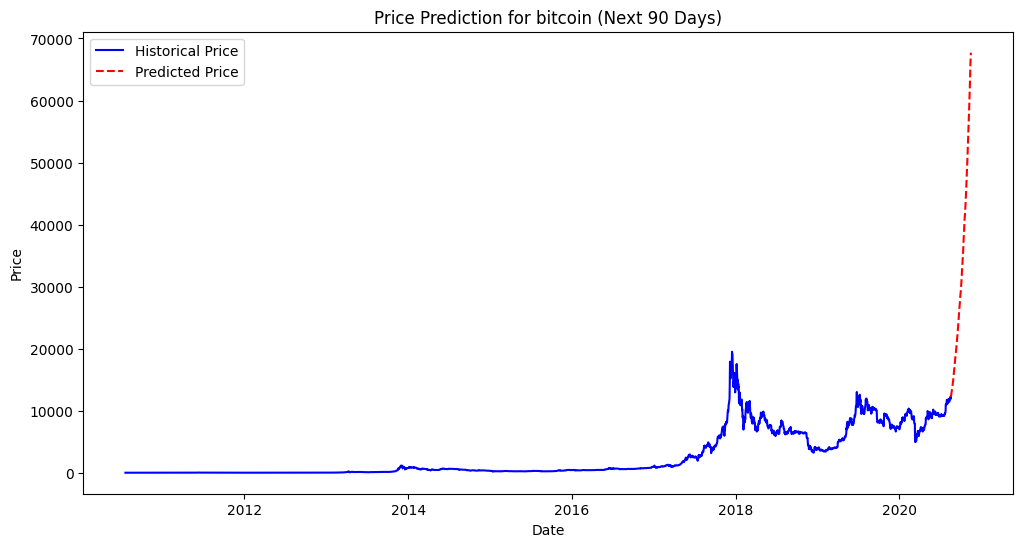

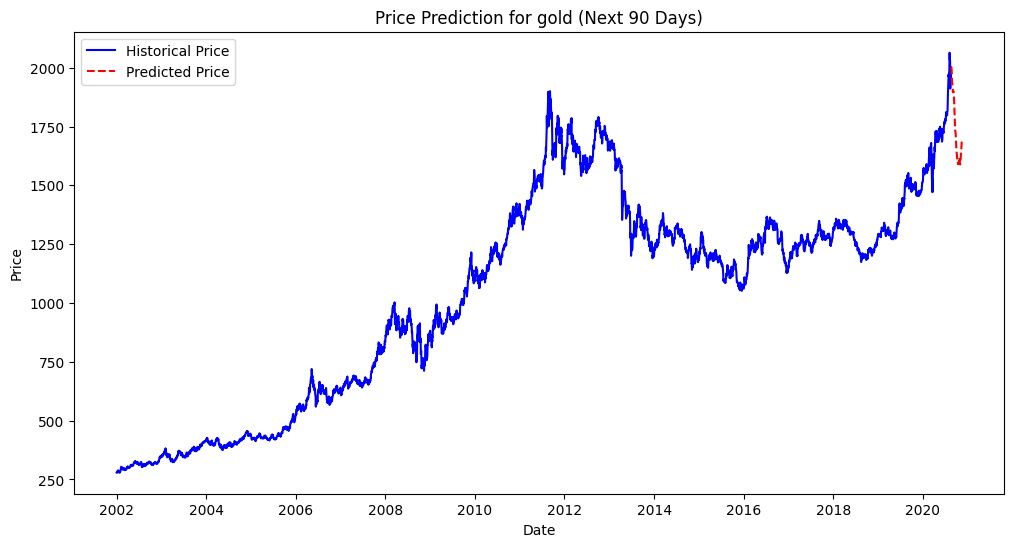

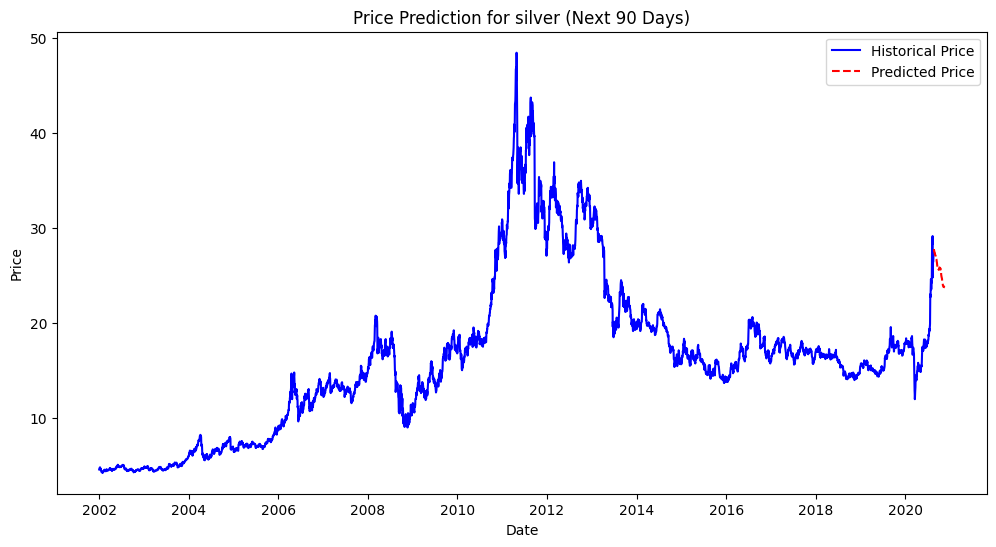

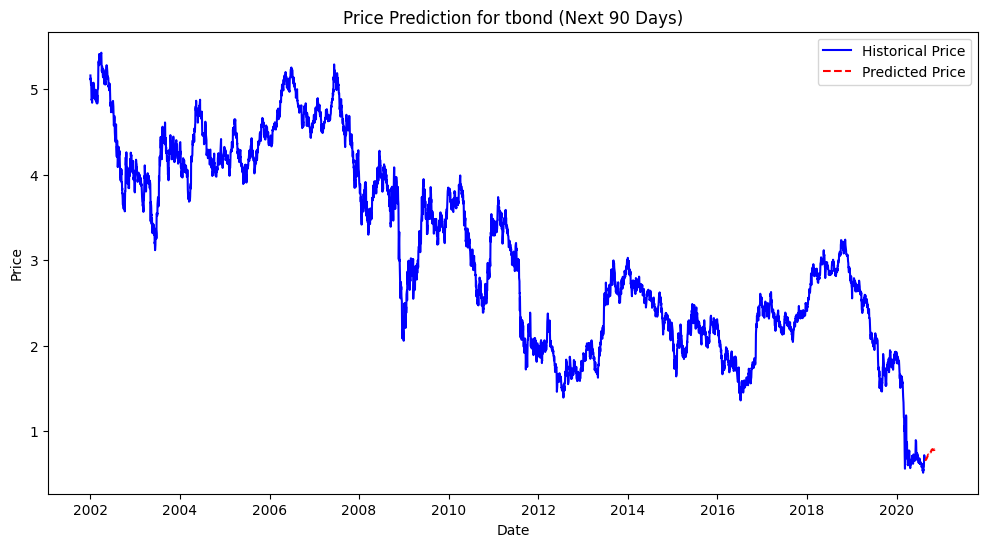

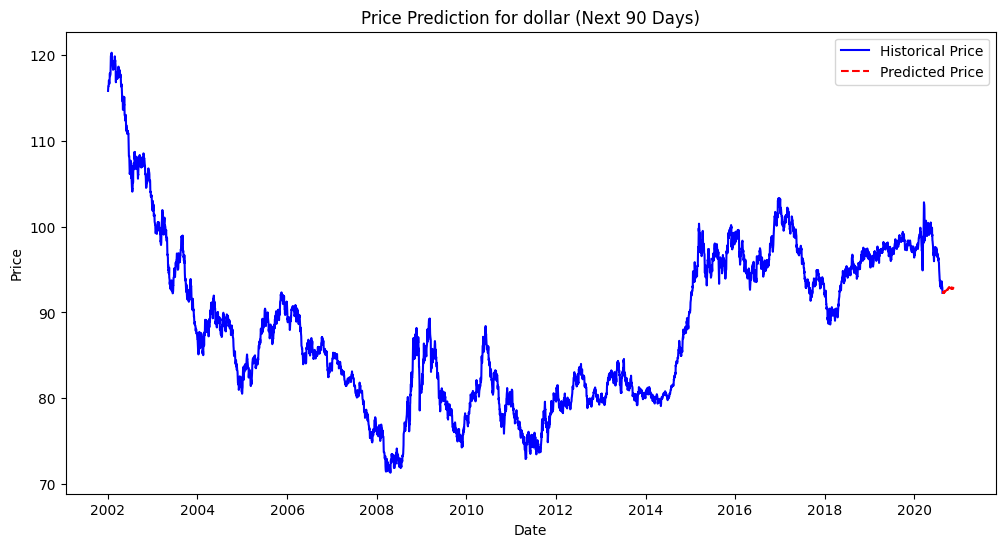

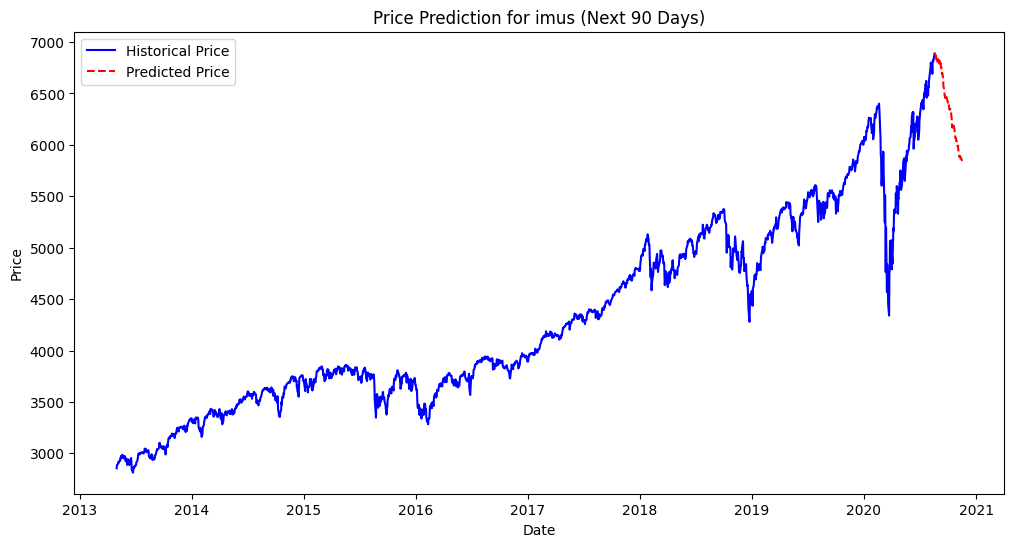

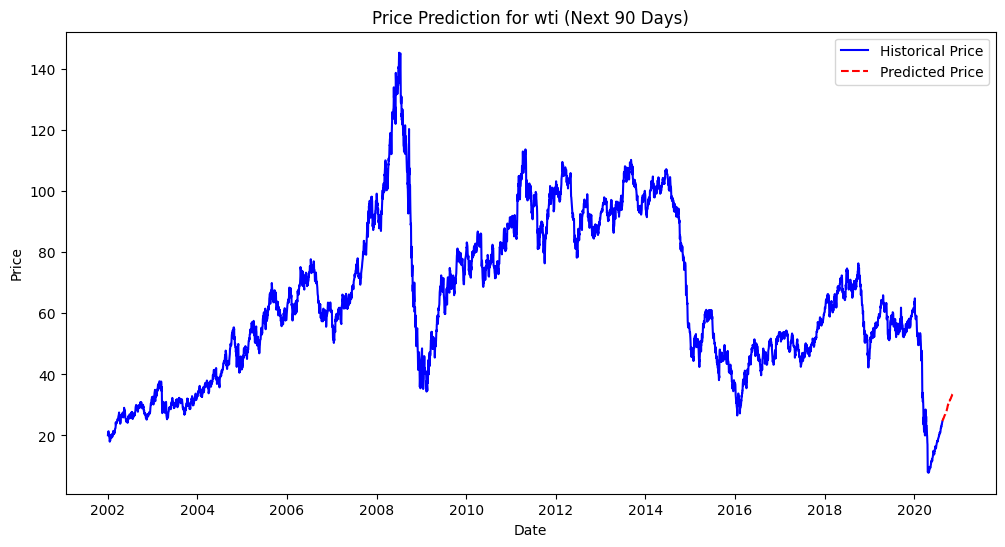

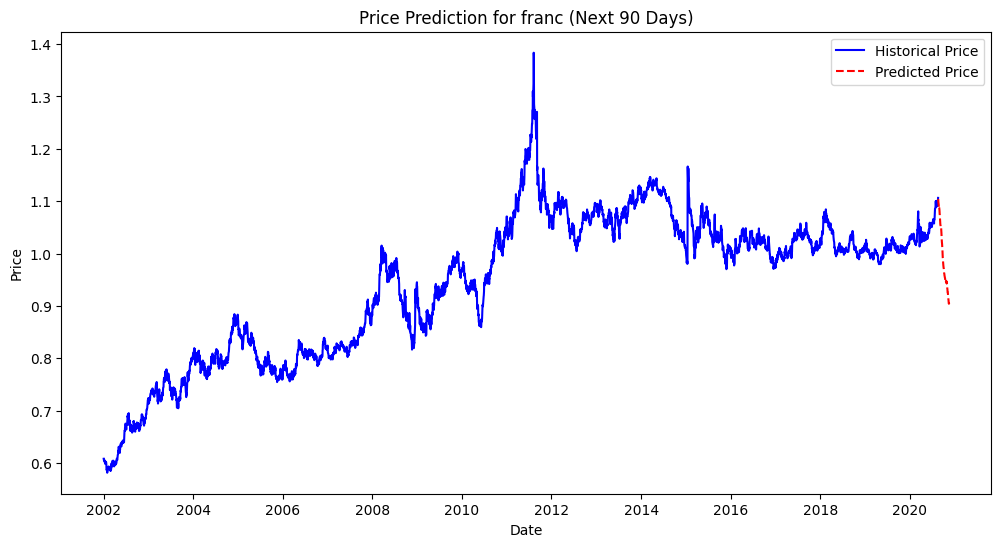

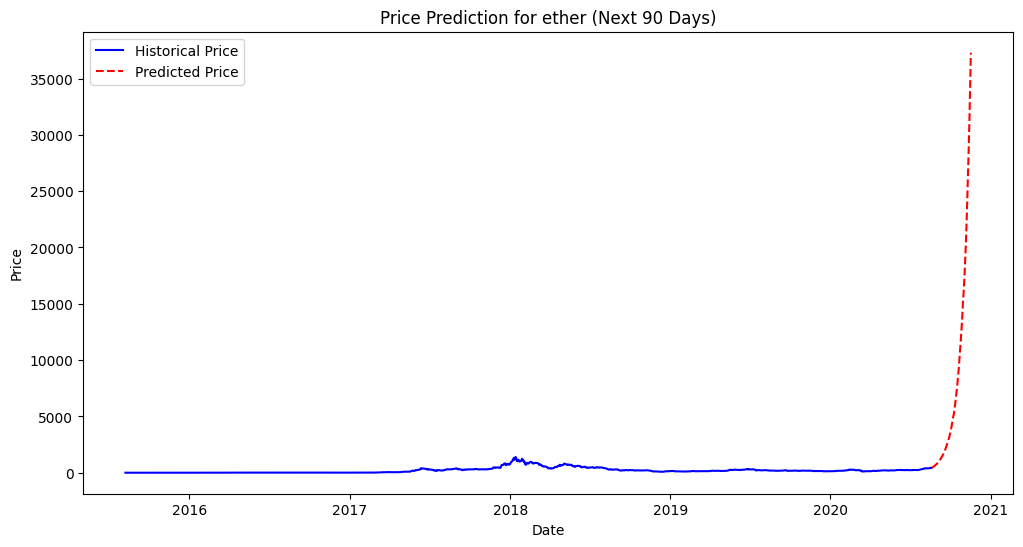

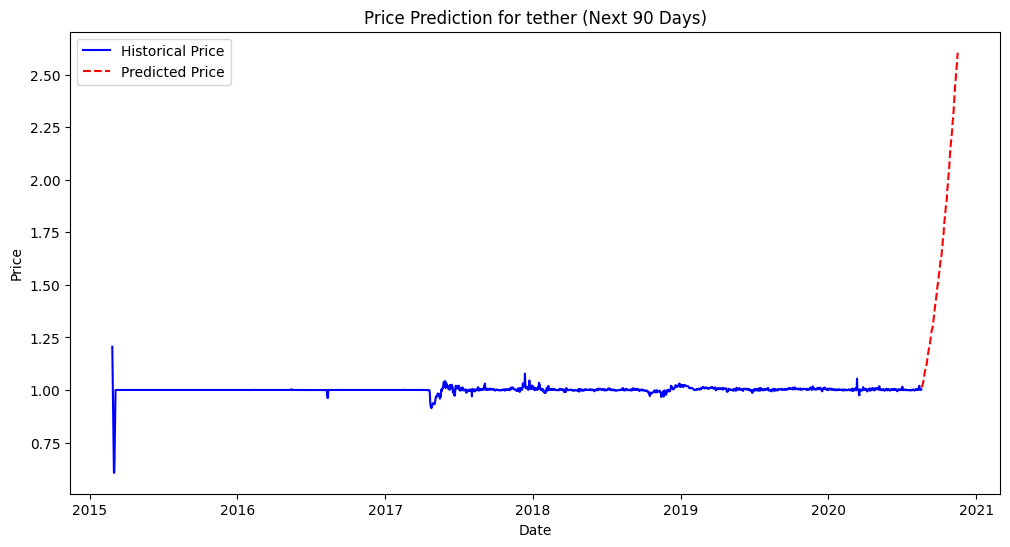

In [47]:


def visualize_predictions(assets_data, predictions, predict_days=90):
    """
    Visualize historical prices and predicted prices for multiple assets.
    
    Args:
    - assets_data: Dictionary of DataFrames containing historical data for each asset.
    - predictions: Dictionary of lists containing predicted prices for each asset.
    - predict_days: Number of prediction days (e.g., 90 days).
    """
    for asset_name, df in assets_data.items():
        # Ensure Date is sorted
        df = df.sort_values('Date')

        # Get the historical price data
        historical_prices = df[['Date', 'Price']].dropna()

        # Generate future dates for the prediction
        last_date = historical_prices['Date'].iloc[-1]
        future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=predict_days)

        # Plot historical and predicted prices
        plt.figure(figsize=(12, 6))
        plt.plot(historical_prices['Date'], historical_prices['Price'], label='Historical Price', color='blue')
        plt.plot(future_dates, predictions[asset_name], label='Predicted Price', linestyle='--', color='red')
        
        # Formatting the plot
        plt.title(f"Price Prediction for {asset_name} (Next {predict_days} Days)")
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.legend()
        plt.show()

# Visualize predictions without re-running the training/predicting steps
visualize_predictions(assets_to_modify, predictions)
